In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, merge, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras import backend


import os
input_dir = './input/'
print(os.listdir(input_dir))

FileNotFoundError: [Errno 2] No such file or directory: './input/'

In [92]:
app_train_df = pd.read_csv(os.path.join(input_dir, 'application_train.csv'))
app_test_df = pd.read_csv(os.path.join(input_dir, 'application_test.csv'))
bureau_df = pd.read_csv(os.path.join(input_dir, 'bureau.csv')).drop(columns=['SK_ID_BUREAU'])
bureau_balance_df = pd.read_csv(os.path.join(input_dir, 'bureau_balance.csv'))
credit_card_df = pd.read_csv(os.path.join(input_dir, 'credit_card_balance.csv')).drop(columns=['SK_ID_PREV'])
pos_cash_df = pd.read_csv(os.path.join(input_dir, 'POS_CASH_balance.csv')).drop(columns=['SK_ID_PREV'])
install_df = pd.read_csv(os.path.join(input_dir, 'installments_payments.csv')).drop(columns=['SK_ID_PREV'])
prev_app_df = pd.read_csv(os.path.join(input_dir, 'previous_application.csv')).drop(columns=['SK_ID_PREV'])

In [93]:
app_train_df.SK_ID_CURR.unique().shape

(307511,)

In [95]:
def aggregate_numeric(df, index, method):
    return df.groupby(index).agg(method).reset_index()

def most_recent_all(df, index, recent_index):
    recent = df.groupby(index)[recent_index].idxmax()
    return df.loc[recent, :]

def most_recent_categorical(df, index, recent_index):
    recent = df.groupby(index)[recent_index].idxmax()
    categories = [index] + df.columns[df.dtypes == 'object'].tolist()
    return df.loc[recent, categories]

In [96]:
# Aggregate bureau information
bureau_average_numerical = aggregate_numeric(bureau_df, 'SK_ID_CURR', 'mean')
bureau_recent_categories = most_recent_categorical(bureau_df, 'SK_ID_CURR', 'DAYS_CREDIT')

In [97]:
# Aggregate credit card information
credit_average_numerical = aggregate_numeric(credit_card_df, 'SK_ID_CURR', 'mean')
credit_recent_categories = most_recent_categorical(credit_card_df, 'SK_ID_CURR', 'MONTHS_BALANCE')

In [98]:
# Aggregate pos 
pos_average_numerical = aggregate_numeric(pos_cash_df, 'SK_ID_CURR', 'mean')
pos_recent_categories = most_recent_categorical(pos_cash_df, 'SK_ID_CURR', 'MONTHS_BALANCE')

In [100]:
# Aggregate installments 
install_average_numerical = aggregate_numeric(install_df, 'SK_ID_CURR', 'mean')

In [99]:
#Previous applications
previous = most_recent_all(prev_app_df, 'SK_ID_CURR', 'DAYS_LAST_DUE')
previous_average_numerical = aggregate_numeric(prev_app_df, 'SK_ID_CURR', 'mean')

In [331]:
current_numerical = list(set(['SK_ID_CURR'] + app_train_df.columns[app_train_df.dtypes != 'object'].tolist()))
current_categories = list(set(['SK_ID_CURR'] + app_train_df.columns[app_train_df.dtypes == 'object'].tolist()))
previous_numerical = list(set(['SK_ID_CURR'] + previous.columns[previous.dtypes != 'object'].tolist()))
previous_categories = list(set(['SK_ID_CURR'] + previous.columns[previous.dtypes == 'object'].tolist()))

merged_numerical = app_train_df[current_numerical].merge(
    previous[previous_numerical], how='left', on='SK_ID_CURR', suffixes=('', '_APP_RECENT')).merge(
    previous_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_APP_AVG')).merge(
    bureau_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_BUREAU_AVG')).merge(
    credit_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_CREDIT_AVG')).merge(
    pos_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_POS_AVG')).merge(
    install_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_INSTALL_AVG'))
merged_numerical.fillna(0, inplace=True)

merged_categories = app_train_df[current_categories].merge(
    previous[previous_categories], how='left', on='SK_ID_CURR', suffixes=('', '_APP_RECENT')).merge(
    bureau_recent_categories, how='left', on='SK_ID_CURR', suffixes=('', '_BUREAU_CAT')).merge(
    credit_recent_categories, how='left', on='SK_ID_CURR', suffixes=('', '_CREDIT_CAT')).merge(
    pos_recent_categories, how='left', on='SK_ID_CURR', suffixes=('', '_POS_CAT'))
merged_categories.fillna('NA', inplace=True)

X = merged_numerical.merge(merged_categories, how='inner', on='SK_ID_CURR')
y = merged_numerical[['TARGET']]
X = X.drop(columns=['SK_ID_CURR', 'TARGET'])

# Income Ratios
# X['LOAN_INCOME_RATIO'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
# X['ANNUITY_INCOME_RATIO'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']

# # Annuity Length
# X['ANNUITY LENGTH'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']

# # Social Ratios
# X['WORKING_LIFE_RATIO'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
# X['INCOME_PER_FAM'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
# X['CHILDREN_RATIO'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']

print('Size of inputs: ', X.shape)

Size of inputs:  (307511, 222)


In [332]:
num_vals_dict = {
    c: list(X[c].unique()) for c in X.columns if X[c].dtype != object
}

cat_vals_dict = {
    c: list(X[c].unique()) for c in X.columns if X[c].dtype == object
}

cat_encoders = {}
for c in cat_vals_dict:
    enc = LabelEncoder()
    enc.fit(cat_vals_dict[c])
    cat_encoders[c] = enc
    X[c] = cat_encoders[c].transform(X[c])
    
num_cols = [c for c in num_vals_dict]
scaler = MinMaxScaler().fit(X[num_cols])
X.loc[:,num_cols] = scaler.transform(X[num_cols])

In [333]:
def build_embedding_network(numerical_inputs, categorical_inputs):
    
    model_out = []
    model_in  = []
    
    for c in categorical_inputs:
        dim = len(categorical_inputs[c])
        input_dim = Input(shape=(1,), dtype='int32', name=c)
        embed_dim = Embedding(dim, dim//2, input_length=1, name='%s_EMBED' % c)(input_dim)
        embed_dim = Dropout(0.1)(embed_dim)
        embed_dim = Reshape((dim//2,))(embed_dim)
        model_out.append(embed_dim)
        model_in.append(input_dim)
    
    input_num = Input(shape=(len(numerical_inputs),), dtype='float32', name='NUMERICAL_INPUTS')
    outputs = Concatenate(axis=1)([*model_out, input_num])
    
    outputs = (Dense(128))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.35))(outputs)
    outputs = (Dense(64))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(32))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    
    model = Model([*model_in, input_num], outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [334]:
def preproc(df, numerical_inputs, categorical_inputs):
    return [df[c].values for c in categorical_inputs] + [df[numerical_inputs].values]

Processing Fold 1
Train on 246008 samples, validate on 61503 samples
Epoch 1/20
246008/246008 [==============================] - 14s 59us/step - loss: 0.3337 - val_loss: 0.2767
Epoch 2/20
246008/246008 [==============================] - 7s 27us/step - loss: 0.2776 - val_loss: 0.2601
Epoch 3/20
246008/246008 [==============================] - 7s 28us/step - loss: 0.2650 - val_loss: 0.2532
Epoch 4/20
246008/246008 [==============================] - 7s 29us/step - loss: 0.2586 - val_loss: 0.2515
Epoch 5/20
246008/246008 [==============================] - 7s 29us/step - loss: 0.2560 - val_loss: 0.2503
Epoch 6/20
246008/246008 [==============================] - 7s 29us/step - loss: 0.2557 - val_loss: 0.2507
Epoch 7/20
246008/246008 [==============================] - 7s 29us/step - loss: 0.2541 - val_loss: 0.2497
Epoch 8/20
246008/246008 [==============================] - 7s 30us/step - loss: 0.2533 - val_loss: 0.2507
Epoch 9/20
246008/246008 [==============================] - 8s 31us/step -

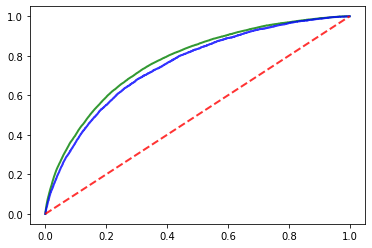

Confusion Matrix:
[[39358 17180]
 [ 1576  3389]]
Processing Fold 2
Train on 246009 samples, validate on 61502 samples
Epoch 1/20
246009/246009 [==============================] - 17s 71us/step - loss: 0.3415 - val_loss: 0.2758
Epoch 2/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2792 - val_loss: 0.2595
Epoch 3/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2641 - val_loss: 0.2529
Epoch 4/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2587 - val_loss: 0.2506
Epoch 5/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2562 - val_loss: 0.2495
Epoch 6/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2548 - val_loss: 0.2496
Epoch 7/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2545 - val_loss: 0.2495
Epoch 8/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2538 - val_loss: 0.2523
Epoch 9/20
246009/246009 

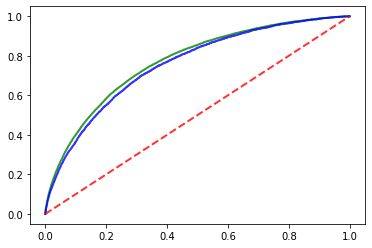

Confusion Matrix:
[[38601 17936]
 [ 1480  3485]]
Processing Fold 3
Train on 246009 samples, validate on 61502 samples
Epoch 1/20
246009/246009 [==============================] - 18s 74us/step - loss: 0.3317 - val_loss: 0.2746
Epoch 2/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2756 - val_loss: 0.2586
Epoch 3/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2618 - val_loss: 0.2534
Epoch 4/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2577 - val_loss: 0.2514
Epoch 5/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2555 - val_loss: 0.2492
Epoch 6/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2546 - val_loss: 0.2491
Epoch 7/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2537 - val_loss: 0.2488
Epoch 8/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2527 - val_loss: 0.2486
Epoch 9/20
246009/246009 

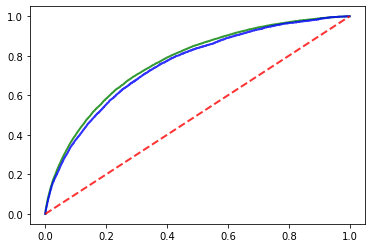

Confusion Matrix:
[[38025 18512]
 [ 1440  3525]]
Processing Fold 4
Train on 246009 samples, validate on 61502 samples
Epoch 1/20
246009/246009 [==============================] - 19s 77us/step - loss: 0.3294 - val_loss: 0.2730
Epoch 2/20
246009/246009 [==============================] - 8s 32us/step - loss: 0.2772 - val_loss: 0.2588
Epoch 3/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2635 - val_loss: 0.2526
Epoch 4/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2586 - val_loss: 0.2507
Epoch 5/20
246009/246009 [==============================] - 8s 31us/step - loss: 0.2561 - val_loss: 0.2500
Epoch 6/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2553 - val_loss: 0.2498
Epoch 7/20
246009/246009 [==============================] - 8s 31us/step - loss: 0.2547 - val_loss: 0.2498
Epoch 8/20
246009/246009 [==============================] - 8s 31us/step - loss: 0.2545 - val_loss: 0.2490
Epoch 9/20
246009/246009 

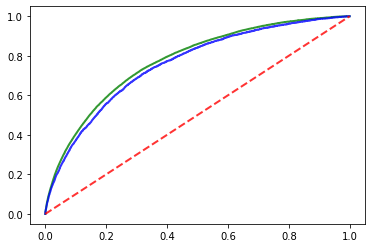

Confusion Matrix:
[[38563 17974]
 [ 1459  3506]]
Processing Fold 5
Train on 246009 samples, validate on 61502 samples
Epoch 1/20
246009/246009 [==============================] - 19s 77us/step - loss: 0.3133 - val_loss: 0.2681
Epoch 2/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2703 - val_loss: 0.2551
Epoch 3/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2602 - val_loss: 0.2502
Epoch 4/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2573 - val_loss: 0.2500
Epoch 5/20
246009/246009 [==============================] - 7s 30us/step - loss: 0.2551 - val_loss: 0.2488
Epoch 6/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2547 - val_loss: 0.2484
Epoch 7/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2542 - val_loss: 0.2483
Epoch 8/20
246009/246009 [==============================] - 7s 29us/step - loss: 0.2535 - val_loss: 0.2477
Epoch 9/20
246009/246009 

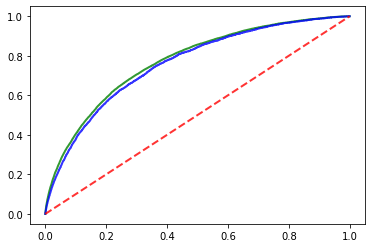

Confusion Matrix:
[[36478 20059]
 [ 1291  3674]]


In [377]:
K = 5
n_epochs = 20

cv_aucs   = []
full_val_preds = np.zeros(np.shape(X)[0])
y_preds = np.zeros((np.shape(X)[0],K))

kfold = StratifiedKFold(
    n_splits = K,
    shuffle = True, 
    random_state=1
)

backend.clear_session()
for i, (train_ind, test_ind) in enumerate(kfold.split(X, y)):
    print('Processing Fold %d' % (i+1))
    X_train = X.loc[train_ind, :]
    y_train = y.loc[train_ind, :].values
    
    X_test = X.loc[test_ind, :]
    y_test = y.loc[test_ind, :].values
    
    X_train_inputs = preproc(X_train, num_vals_dict, cat_vals_dict)    
    X_test_inputs = preproc(X_test, num_vals_dict, cat_vals_dict)
    
    model = build_embedding_network(num_vals_dict, cat_vals_dict)
    model.fit(
        X_train_inputs, y_train,
        validation_data=(X_test_inputs, y_test),
        epochs=n_epochs,
        batch_size=4096,
        verbose=1)
    
    predicted_train = model.predict(X_train_inputs)
    predicted_test = model.predict(X_test_inputs)
    
    # Evaluations
    cv_auc  = roc_auc_score(y_train, predicted_train)
    print('Train AUC: %f' % cv_auc)
    cv_auc  = roc_auc_score(y_test, predicted_test)
    print('Test AUC: %f' % cv_auc)

    fpr, tpr, thresholds = roc_curve(y_train, predicted_train)
    plt.plot(fpr, tpr, color='g', lw=2, alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_test, predicted_test)
    plt.plot(fpr, tpr, color='b', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.show()

    best_cutoff = np.argmax(tpr - fpr)

    y_pred = predicted_test
    y_pred[y_pred >= thresholds[best_cutoff]] = 1
    y_pred[y_pred < thresholds[best_cutoff]] = 0
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predicted_test))